RL Final Project Code


Akhil Golla, ag4812

Goals of this project:

Test Decision Transformers using GPT2 Models of different sizes

Test Decision Transformers using other Transformer Models

See how the performance compares to other methods for mujoco dataset

In [5]:
#Include this at the top of your colab code
import os
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


performance hint: /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx:67:5: Exception check on 'c_warning_callback' will always require the GIL to be acquired.
Possible solutions:
	1. Declare 'c_warning_callback' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
	2. Use an 'int' return type on 'c_warning_callback' to allow an error code to be returned.
performance hint: /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx:104:5: Exception check on 'c_error_callback' will always require the GIL to be acquired.
Possible solutions:
	1. Declare 'c_error_callback' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
	2. Use an 'int' return type on 'c_error_callback' to allow an error code to be returned.

Error compiling Cython file:
------------------------------------------------------------
...
    See c_warning_callback, which is the C wrapper to the user defin

CompileError: /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx

In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

!pip install gym

!pip install free-mujoco-py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglew-dev is already the newest version (2.2.0-4).
libgl1-mesa-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
libosmesa6-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
software-properties-common is already the newest version (0.99.22.9).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
patchelf is already the newest version (0.14.3-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
! pip install mujoco

In [2]:
! pip install transformers
! pip install datasets
! pip install glfw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [28]:
import gym
import numpy as np

import collections
import pickle

from datasets import load_dataset
import transformers

import torch
from torch import nn

import matplotlib.pyplot as plt


write collate_fn, build dataloader

In [26]:
GAMMA = 0.99
MAX_LEN = 32
MAX_EP_LEN = 1000
BATCH_SIZE = 16
HIDDEN_SIZE = 128
SCALE = 1000

ENV_NAME = 'HalfCheetah-v4'
TARGET = [12000, 6000]

EPOCHS = 10


In [6]:
# make environment

env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]


Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

In [7]:
# load dataset
dataset = load_dataset("edbeeching/decision_transformer_gym_replay", "halfcheetah-medium-v2")
print(len(dataset['train']['observations']))
print("Success")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

1000
Success


To-Do

add max len with random in collate ~ 1 hour - done

write trajectory model and test ~ 10 hr - in progress



In [8]:
def discount_cumsum(x, gamma=GAMMA):
    discount_cumsum = np.zeros_like(x)
    discount_cumsum[-1] = x[-1]
    for t in reversed(range(len(x)-1)):
        discount_cumsum[t] = x[t] + gamma * discount_cumsum[t+1]
    return discount_cumsum

def collate_fn(batch):

  # observations : (B X MAX_LEN x 17)
  # actions : (B X MAX_LEN X 6)
  # rewards : (B X MAX_LEN)
  # rewards-to-go : (B X MAX_LEN)
  # dones : (B X MAX_LEN )

  # restrain to size of MAX_LEN

  # generate segments of MAX_LEN

  batch_size = len(batch)

  indices = [np.random.randint(0, 1000 - MAX_LEN) for _ in range(len(batch))]

  observations = [batch[i]['observations'][indices[i] : indices[i] + MAX_LEN] for i in range(len(batch))]
  actions = [batch[i]['actions'][indices[i] : indices[i] + MAX_LEN] for i in range(len(batch))]
  rewards = [batch[i]['rewards'][indices[i] : indices[i] + MAX_LEN] for i in range(len(batch))]
  rewards_to_go = [discount_cumsum(r, GAMMA) for r in rewards] #/ SCALE
  dones = [batch[i]['dones'][indices[i] : indices[i] + MAX_LEN] for i in range(len(batch))]


  indices = torch.tensor(indices).reshape(batch_size, -1)
  observations = torch.tensor(observations).float()
  actions  = torch.tensor(actions).float()
  rewards  = torch.tensor(rewards).float().reshape(batch_size, -1, 1)
  rewards_to_go  = torch.tensor(rewards_to_go).float().reshape(batch_size, -1, 1)
  dones  = torch.tensor(dones).float()

  return indices, observations, actions, rewards, rewards_to_go, dones

dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn)



In [30]:
#normalize state??

# understand gpt mask

In [19]:
# adapted from https://github.com/kzl/decision-transformer


# custom layer to make positional embeddings 0 ( effectively removing them in the forward function)
class ZeroLayer(nn.Module):
    def __init__(self, seq_length = MAX_LEN, hidden_size = HIDDEN_SIZE):
        super().__init__()
        self.dim2 = seq_length * 3
        self.dim3 = hidden_size

    def forward(self, inputs):
        # Create a tensor filled with zeros with the same shape as the input
        return torch.zeros((inputs.shape[0], self.dim2, self.dim3))


class DecisionTransformer(nn.Module):
  def __init__(self, state_dim, act_dim, hidden_size=HIDDEN_SIZE, max_length=MAX_LEN, max_episode_len=MAX_EP_LEN, **kwargs):
    super().__init__()

    self.state_dim = state_dim
    self.act_dim = act_dim
    self.max_length = max_length
    self.hidden_size = hidden_size

    config = transformers.GPT2Config(
        vocab_size=1,  # doesn't matter -- we don't use the vocab
        n_embd=hidden_size,
        **kwargs,
    )

    self.transformer = transformers.GPT2Model(config)

    self.transformer.wpe = ZeroLayer(self.max_length, self.hidden_size)


    self.embed_timestep = nn.Embedding(max_episode_len, hidden_size)
    self.embed_return = torch.nn.Linear(1, hidden_size)
    self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
    self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)

    self.embed_ln = nn.LayerNorm(hidden_size)

    self.predict_state = torch.nn.Linear(hidden_size, self.state_dim)
    self.predict_action = nn.Sequential(
        *([nn.Linear(hidden_size, self.act_dim)] + [nn.Tanh()])
    )
    self.predict_return = torch.nn.Linear(hidden_size, 1)




  def forward(self, timesteps, states, actions, rewards, rewards_to_go, masks=None, attention_mask=None):
    # "masked" tokens or unspecified inputs can be passed in as None
    self.transformer.wpe = ZeroLayer(self.max_length, self.hidden_size)

    batch_size, seq_length = states.shape[0], states.shape[1]

    if attention_mask is None: attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long)


     # embed each modality with a different head
    state_embeddings = self.embed_state(states)

    action_embeddings = self.embed_action(actions)

    rewards_to_go_embeddings = self.embed_return(rewards_to_go)

    time_embeddings = self.embed_timestep(timesteps)




    # time embeddings are treated similar to positional embeddings
    state_embeddings = state_embeddings + time_embeddings
    action_embeddings = action_embeddings + time_embeddings
    rewards_to_go_embeddings = rewards_to_go_embeddings + time_embeddings



    # this makes the sequence look like (R_1, s_1, a_1, R_2, s_2, a_2, ...)
    # which works nice in an autoregressive sense since states predict actions
    stacked_inputs = torch.stack(
        (rewards_to_go_embeddings, state_embeddings, action_embeddings), dim=1
    ).permute(0, 2, 1, 3).reshape(batch_size, 3*seq_length, self.hidden_size)
    stacked_inputs = self.embed_ln(stacked_inputs)


    # to make the attention mask fit the stacked inputs, have to stack it as well
    stacked_attention_mask = torch.stack(
        (attention_mask, attention_mask, attention_mask), dim=1
    ).permute(0, 2, 1).reshape(batch_size, 3*seq_length)



    # we feed in the input embeddings (not word indices as in NLP) to the model
    transformer_outputs = self.transformer(
        inputs_embeds=stacked_inputs,
        attention_mask=stacked_attention_mask,
    )
    x = transformer_outputs['last_hidden_state']

    # reshape x so that the second dimension corresponds to the original
    # returns (0), states (1), or actions (2); i.e. x[:,1,t] is the token for s_t
    x = x.reshape(batch_size, seq_length, 3, self.hidden_size).permute(0, 2, 1, 3)

    # get predictions
    return_preds = self.predict_return(x[:,2])  # predict next return given state and action
    state_preds = self.predict_state(x[:,2])    # predict next state given state and action
    action_preds = self.predict_action(x[:,1])  # predict next action given state

    return state_preds, action_preds, return_preds

  def get_action(self, states, actions, rewards, returns_to_go, timesteps, **kwargs):

    # we don't care about the past rewards in this model

    states = states.reshape(1, -1, self.state_dim)
    actions = actions.reshape(1, -1, self.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)



    if self.max_length is not None:

        states = states[:,-self.max_length:]
        actions = actions[:,-self.max_length:]
        returns_to_go = returns_to_go[:,-self.max_length:]
        timesteps = timesteps[:,-self.max_length:]


        # pad all tokens to sequence length
        attention_mask = torch.cat([torch.zeros(self.max_length-states.shape[1]), torch.ones(states.shape[1])])
        attention_mask = attention_mask.to(dtype=torch.long, device=states.device).reshape(1, -1)

        states = torch.cat(
            [torch.zeros((states.shape[0], self.max_length-states.shape[1], self.state_dim), device=states.device), states],
            dim=1).to(dtype=torch.float32)
        actions = torch.cat(
            [torch.zeros((actions.shape[0], self.max_length - actions.shape[1], self.act_dim),
                        device=actions.device), actions],
            dim=1).to(dtype=torch.float32)

        returns_to_go = torch.cat(
            [torch.zeros((returns_to_go.shape[0], self.max_length-returns_to_go.shape[1], 1), device=returns_to_go.device), returns_to_go],
            dim=1).to(dtype=torch.float32)

        timesteps = torch.cat(
            [torch.zeros((timesteps.shape[0], self.max_length-timesteps.shape[1]), device=timesteps.device), timesteps],
            dim=1
        ).to(dtype=torch.long)

    else:
        attention_mask = None
    # self, timesteps, states, actions, rewards, rewards_to_go, masks=None, attention_mask=None
    _, action_preds, return_preds = self.forward(
        states = states, actions = actions, rewards = None, rewards_to_go = returns_to_go, timesteps = timesteps, attention_mask=attention_mask, **kwargs)
    return action_preds[0,-1]

model = DecisionTransformer(
            state_dim=state_dim,
            act_dim=act_dim,
            max_length=MAX_LEN,
            max_ep_len=MAX_EP_LEN,
            hidden_size=128,
            n_layer=3,
            n_head=1,
            n_inner=4*128,
            activation_function='relu',
            n_positions=1024,
            resid_pdrop=0.1,
            attn_pdrop=0.1,
        )

In [49]:
print(model)

DecisionTransformer(
  (transformer): GPT2Model(
    (wte): Embedding(1, 128)
    (wpe): ZeroLayer()
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (embed_timestep): Embedding(1000, 128)
  (embed_return): Linear(in_features=1, out_features=128, bias=True)
  (embed_state): Linear(in_features=17, out_features=128, bias=True)
  (embed_action): Linear(in_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
state_dim

17

In [21]:
act_dim

6

In [22]:
# state_preds, action_preds, reward_preds = self.model.forward(
#             states, actions, rewards, rtg[:,:-1], timesteps, attention_mask=attention_mask,
#         )

In [24]:
# optimizer and loss function

def action_loss(action_pred, action):
  return torch.mean((action_pred - action)**2)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [27]:
# train model
model.train()
total_loss = []

for e in range(EPOCHS):
  epoch_loss = 0
  # epoch_acc = 0
  batch_count = 0

  for timesteps, observations, actions, rewards, rewards_to_go, dones in dataloader:
    batch_count += 1
    action_target = actions.clone()

    state_preds, action_preds, reward_preds = model.forward( timesteps, observations, actions, rewards, rewards_to_go, attention_mask=None )

    action_preds = action_preds.reshape(-1, act_dim)
    action_target = action_target.reshape(-1, act_dim)

    loss = action_loss(action_preds, action_target)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), .25)
    optimizer.step()


    with torch.no_grad():
      epoch_loss += torch.mean((action_preds-action_target)**2).detach().cpu().item()

  total_loss.append(epoch_loss / batch_count)

print(total_loss)



# evaluate

[0.3346995649829743, 0.21877122303796193, 0.19404108491208819, 0.18449972049584465, 0.16942154580638522, 0.16504752068292528, 0.15703796323329683, 0.15385001850506616, 0.14695220038531318, 0.14519832164995253]


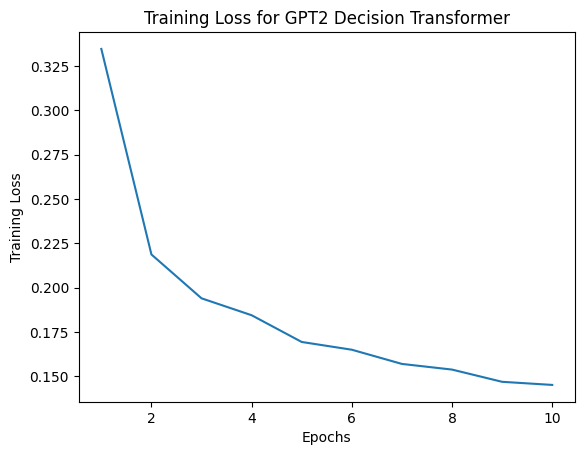

In [29]:
plt.plot([1,2,3,4,5,6,7,8,9, 10], total_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss for GPT2 Decision Transformer")

plt.show()

In [ ]:
# Eval model

model.eval()
env.reset()

cumilative_reward = []
target = -20

total_reward = 0

states = torch.zeros((0, state_dim)).float()
actions = torch.zeros((0, act_dim)).float()
rewards = torch.zeros(0).float()
timesteps = torch.tensor(0, dtype=torch.long).reshape(1, 1)



for i in range(MAX_EP_LEN):

  actions = torch.cat([actions, torch.zeros((1, act_dim))], dim=0)
  rewards = torch.cat([rewards, torch.zeros(1)])

  target_return = torch.tensor(total_reward + target, dtype=torch.float32).reshape(1, 1)

  # get action prediction
  action = model.get_action(
            states=states,
            actions=actions.to(dtype=torch.float32),
            rewards=rewards.to(dtype=torch.float32),
            returns_to_go=target_return.to(dtype=torch.float32),
            timesteps=timesteps.to(dtype=torch.long),
        )


  # update actions
  actions[-1] = action

  # update run action
  state, reward, done, _ = env.step(action.detach().numpy())




  # update states
  cur_state = torch.from_numpy(state).reshape(1, state_dim)
  states = torch.cat([states, cur_state], dim=0)

  # update rewards
  rewards[-1] = reward

  # update timesteps
  timesteps = torch.cat([timesteps, torch.ones((1, 1)) * (i)], dim=1)


  # print(total_reward)
  total_reward += reward
  cumilative_reward.append(total_reward)



In [36]:
cumilative_reward[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.02755723555714293

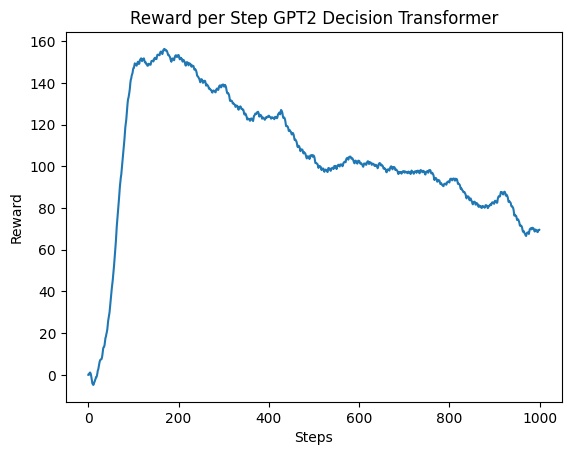

In [42]:
plt.plot(list(range(MAX_EP_LEN)), cumilative_reward)
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Reward per Step GPT2 Decision Transformer")

plt.show()

In [121]:
action_preds.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([16, 32, 6])

In [57]:
# BERT MODEL


class BertDecisionTransformer(nn.Module):
  def __init__(self, state_dim, act_dim, hidden_size=HIDDEN_SIZE, max_length=MAX_LEN, max_episode_len=MAX_EP_LEN, **kwargs):
    super().__init__()

    self.state_dim = state_dim
    self.act_dim = act_dim
    self.max_length = max_length
    self.hidden_size = hidden_size

    config = transformers.BertConfig(
        vocab_size=1,  # doesn't matter -- we don't use the vocab
        hidden_size=hidden_size,
        num_attention_heads = 4,
        num_hidden_layers = 4,
        intermediate_size = 1024,
        **kwargs,
    )

    self.transformer = transformers.BertModel(config)

    # self.transformer.token_type_embeddings = ZeroLayer(self.max_length, self.hidden_size)


    self.embed_timestep = nn.Embedding(max_episode_len, hidden_size)
    self.embed_return = torch.nn.Linear(1, hidden_size)
    self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
    self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)

    self.embed_ln = nn.LayerNorm(hidden_size)

    self.predict_state = torch.nn.Linear(hidden_size, self.state_dim)
    self.predict_action = nn.Sequential(
        *([nn.Linear(hidden_size, self.act_dim)] + [nn.Tanh()])
    )
    self.predict_return = torch.nn.Linear(hidden_size, 1)




  def forward(self, timesteps, states, actions, rewards, rewards_to_go, masks=None, attention_mask=None):
    # "masked" tokens or unspecified inputs can be passed in as None
    # self.transformer.wpe = ZeroLayer(self.max_length, self.hidden_size)

    batch_size, seq_length = states.shape[0], states.shape[1]

    if attention_mask is None: attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long)


     # embed each modality with a different head
    state_embeddings = self.embed_state(states)

    action_embeddings = self.embed_action(actions)

    rewards_to_go_embeddings = self.embed_return(rewards_to_go)

    time_embeddings = self.embed_timestep(timesteps)




    # time embeddings are treated similar to positional embeddings
    state_embeddings = state_embeddings + time_embeddings
    action_embeddings = action_embeddings + time_embeddings
    rewards_to_go_embeddings = rewards_to_go_embeddings + time_embeddings



    # this makes the sequence look like (R_1, s_1, a_1, R_2, s_2, a_2, ...)
    # which works nice in an autoregressive sense since states predict actions
    stacked_inputs = torch.stack(
        (rewards_to_go_embeddings, state_embeddings, action_embeddings), dim=1
    ).permute(0, 2, 1, 3).reshape(batch_size, 3*seq_length, self.hidden_size)
    stacked_inputs = self.embed_ln(stacked_inputs)


    # to make the attention mask fit the stacked inputs, have to stack it as well
    stacked_attention_mask = torch.stack(
        (attention_mask, attention_mask, attention_mask), dim=1
    ).permute(0, 2, 1).reshape(batch_size, 3*seq_length)



    # we feed in the input embeddings (not word indices as in NLP) to the model
    transformer_outputs = self.transformer(
        inputs_embeds=stacked_inputs,
        attention_mask=stacked_attention_mask,
    )
    x = transformer_outputs['last_hidden_state']

    # reshape x so that the second dimension corresponds to the original
    # returns (0), states (1), or actions (2); i.e. x[:,1,t] is the token for s_t
    x = x.reshape(batch_size, seq_length, 3, self.hidden_size).permute(0, 2, 1, 3)

    # get predictions
    return_preds = self.predict_return(x[:,2])  # predict next return given state and action
    state_preds = self.predict_state(x[:,2])    # predict next state given state and action
    action_preds = self.predict_action(x[:,1])  # predict next action given state

    return state_preds, action_preds, return_preds

  def get_action(self, states, actions, rewards, returns_to_go, timesteps, **kwargs):

    # we don't care about the past rewards in this model

    states = states.reshape(1, -1, self.state_dim)
    actions = actions.reshape(1, -1, self.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)



    if self.max_length is not None:

        states = states[:,-self.max_length:]
        actions = actions[:,-self.max_length:]
        returns_to_go = returns_to_go[:,-self.max_length:]
        timesteps = timesteps[:,-self.max_length:]


        # pad all tokens to sequence length
        attention_mask = torch.cat([torch.zeros(self.max_length-states.shape[1]), torch.ones(states.shape[1])])
        attention_mask = attention_mask.to(dtype=torch.long, device=states.device).reshape(1, -1)

        states = torch.cat(
            [torch.zeros((states.shape[0], self.max_length-states.shape[1], self.state_dim), device=states.device), states],
            dim=1).to(dtype=torch.float32)
        actions = torch.cat(
            [torch.zeros((actions.shape[0], self.max_length - actions.shape[1], self.act_dim),
                        device=actions.device), actions],
            dim=1).to(dtype=torch.float32)

        returns_to_go = torch.cat(
            [torch.zeros((returns_to_go.shape[0], self.max_length-returns_to_go.shape[1], 1), device=returns_to_go.device), returns_to_go],
            dim=1).to(dtype=torch.float32)

        timesteps = torch.cat(
            [torch.zeros((timesteps.shape[0], self.max_length-timesteps.shape[1]), device=timesteps.device), timesteps],
            dim=1
        ).to(dtype=torch.long)

    else:
        attention_mask = None
    # self, timesteps, states, actions, rewards, rewards_to_go, masks=None, attention_mask=None
    _, action_preds, return_preds = self.forward(
        states = states, actions = actions, rewards = None, rewards_to_go = returns_to_go, timesteps = timesteps, attention_mask=attention_mask, **kwargs)
    return action_preds[0,-1]

Bert_model = BertDecisionTransformer(
            state_dim=state_dim,
            act_dim=act_dim,
            max_length=MAX_LEN,
            max_ep_len=MAX_EP_LEN,
            hidden_size=128,
            n_layer=3,
            n_head=1,
            n_inner=4*128,
            activation_function='relu',
            n_positions=1024,
            resid_pdrop=0.1,
            attn_pdrop=0.1,
        )

In [55]:
print(Bert_model)

BertDecisionTransformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(1, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elem

In [58]:
Bert_model.train()
bert_total_loss = []


bert_optimizer = torch.optim.AdamW(Bert_model.parameters(), lr=1e-4, weight_decay=1e-4)

for e in range(EPOCHS):
  epoch_loss = 0
  # epoch_acc = 0
  batch_count = 0

  for timesteps, observations, actions, rewards, rewards_to_go, dones in dataloader:
    batch_count += 1
    action_target = actions.clone()

    state_preds, action_preds, reward_preds = Bert_model.forward( timesteps, observations, actions, rewards, rewards_to_go, attention_mask=None )

    action_preds = action_preds.reshape(-1, act_dim)
    action_target = action_target.reshape(-1, act_dim)

    loss = action_loss(action_preds, action_target)

    bert_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(Bert_model.parameters(), .25)
    bert_optimizer.step()


    with torch.no_grad():
      epoch_loss += torch.mean((action_preds-action_target)**2).detach().cpu().item()

  bert_total_loss.append(epoch_loss / batch_count)

  print(e)

print(bert_total_loss)


0
1
2
3
4
5
6
7
8
9
[0.3392858585667989, 0.2119657120534352, 0.19356209370825025, 0.17573048339949715, 0.1711715871379489, 0.16342443984652322, 0.1552450449930297, 0.15251021725790842, 0.14597886706155444, 0.14507393621736103]


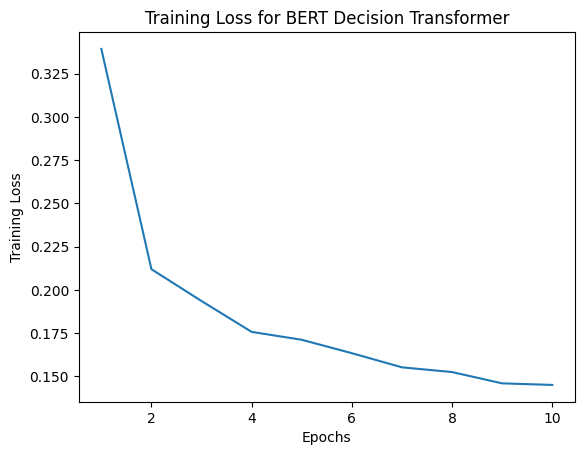

In [65]:
plt.plot([1,2,3,4,5,6,7,8,9, 10], bert_total_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss for BERT Decision Transformer")

plt.show()

In [63]:
# Eval model

Bert_model.eval()
env.reset()

bert_cumilative_reward = []
target = -20

bert_total_reward = 0

states = torch.zeros((0, state_dim)).float()
actions = torch.zeros((0, act_dim)).float()
rewards = torch.zeros(0).float()
timesteps = torch.tensor(0, dtype=torch.long).reshape(1, 1)



for i in range(MAX_EP_LEN):

  actions = torch.cat([actions, torch.zeros((1, act_dim))], dim=0)
  rewards = torch.cat([rewards, torch.zeros(1)])

  target_return = torch.tensor(total_reward + target, dtype=torch.float32).reshape(1, 1)

  # get action prediction
  action = Bert_model.get_action(
            states=states,
            actions=actions.to(dtype=torch.float32),
            rewards=rewards.to(dtype=torch.float32),
            returns_to_go=target_return.to(dtype=torch.float32),
            timesteps=timesteps.to(dtype=torch.long),
        )


  # update actions
  actions[-1] = action

  # update run action
  state, reward, done, _ = env.step(action.detach().numpy())




  # update states
  cur_state = torch.from_numpy(state).reshape(1, state_dim)
  states = torch.cat([states, cur_state], dim=0)

  # update rewards
  rewards[-1] = reward

  # update timesteps
  timesteps = torch.cat([timesteps, torch.ones((1, 1)) * (i)], dim=1)


  # print(total_reward)
  bert_total_reward += reward
  bert_cumilative_reward.append(bert_total_reward)

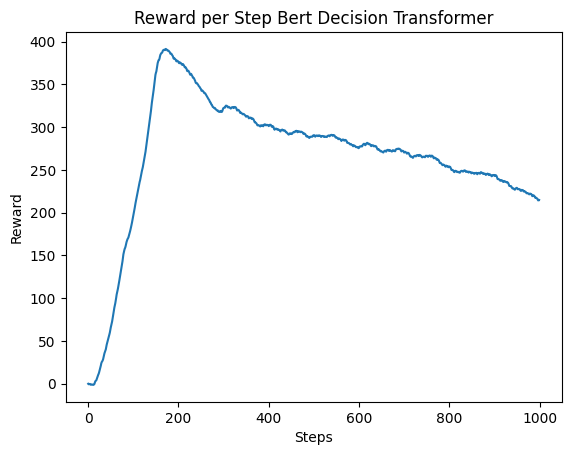

In [64]:
plt.plot(list(range(MAX_EP_LEN)), bert_cumilative_reward)
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Reward per Step Bert Decision Transformer")

plt.show()

In [66]:
print(sum(p.numel() for p in model.parameters()))


730008


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
print(sum(p.numel() for p in Bert_model.parameters()))


1536920


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
print(np.max(cumilative_reward))

156.2553421993189


In [70]:
print(np.max(bert_cumilative_reward))

391.46459168242365
